In [1]:
import warnings
#warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"
warnings.filterwarnings('ignore')

In [2]:
import os
import re
import time
import random
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import scikitplot as skplt
from IPython.display import display, Markdown
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.compat import v1 as tf_compat_v1
from sklearn import preprocessing, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
atacks = ['Normal', 'SYN_Flooding', 'ACK_Flooding', 'Port_Scanning', 'OS_Version_Detection', 'HTTP_Flooding', 'Telnet_Bruteforce', 'UDP_Flooding']#]
packets=r'D:/Документы/Нейронки/perceptron/packets'
new_packets=r'D:/Документы/Нейронки/perceptron/packets_new'

    Устанавливаем восстанавливаемые значения

In [4]:
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf_compat_v1.set_random_seed(seed_value)
# 5. Configure a new global `tensorflow` session
session_conf = tf_compat_v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf_compat_v1.Session(graph=tf_compat_v1.get_default_graph(), config=session_conf)
tf_compat_v1.keras.backend.set_session(sess)

    Работа с датасетом

In [5]:
def num_pack_atack(data: pd.DataFrame) -> list:
    cat_count = list()
    for cat in set(data.category):
        cat_count.append([cat, (data.category == cat).astype(int).sum()])
    for cat in cat_count:
        print(cat[0],':',cat[1])
    print('Total packages :', len(data))
    type_of_attack = [cat[0] for cat in cat_count]
    return type_of_attack

def load_dataset(packets: str):
    dfs = list()
    with os.scandir(packets) as it:
        for entry in it:
            if entry.name.endswith('.csv') and entry.is_file():
                cat = re.findall(r'-([^-]*?).csv', entry.name)[0]
                
                if cat not in atacks or (cat == 'Normal' and 'benign' not in entry.name):
                    continue
                dfs.append(pd.read_csv(entry.path))
                dfs[-1] = dfs[-1].join(pd.DataFrame(np.full([len(dfs[-1])], cat), columns=['category']))
    data = pd.concat(dfs)
    data = data.replace('Infinity', np.nan).replace('NaN', np.nan).replace([np.inf, -np.inf], np.nan)    
    type_of_attack = num_pack_atack(data)
    print()    
    data = data.drop(columns=[c for c in data.columns if c.endswith('.sum')])
    data = data.drop(columns=[c for c in data.columns if 'port' in c and 'std' not in c])
    data = data.where(pd.notna(data['proto'])).dropna(how='all')
    data.index = range(len(data))
    data = data.fillna(0.0)   
    return data, type_of_attack

In [6]:
data, type_attack = load_dataset(packets)

Port_Scanning : 15845
Telnet_Bruteforce : 163
ACK_Flooding : 30892
UDP_Flooding : 2
HTTP_Flooding : 3622
SYN_Flooding : 59442
Normal : 372
OS_Version_Detection : 424
Total packages : 110762



In [7]:
data.head()

,ip.flags.rb.mean,ip.flags.df.mean,ip.flags.mf.mean,tcp.flags.res.mean,tcp.flags.ns.mean,tcp.flags.cwr.mean,tcp.flags.ecn.mean,tcp.flags.urg.mean,tcp.flags.ack.mean,tcp.flags.push.mean,...,tcp.window_size_value.mean,count,duration,int.std,int.min,int.max,int.mean,prate,proto,category
0,0.0,0.999955,0.0,0.000045,0.000023,0.000023,0.000023,0.000045,0.99991,0.158968,...,11282.7179,44229.0,105.413098,0.01,0.000067,0.159526,0.002383,419.568354,6.0,Normal
1,0.0,1.000000,0.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,2005.0000,1.0,0.050493,0.00,0.050493,0.050493,0.050493,19.804725,6.0,Normal
2,0.0,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,62522.0000,1.0,0.000652,0.00,0.000652,0.000652,0.000652,1533.742331,6.0,Normal
3,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,...,1869.0000,1.0,0.000080,0.00,0.000080,0.000080,0.000080,12500.000000,6.0,Normal
4,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0000,1.0,0.000291,0.00,0.000291,0.000291,0.000291,3436.426117,6.0,Normal


    Перемешиваем данные датасета, потому что изначально в нем атаки следуют по порядку

In [8]:
data = shuffle(data, random_state=seed_value)

In [9]:
data.head()

,ip.flags.rb.mean,ip.flags.df.mean,ip.flags.mf.mean,tcp.flags.res.mean,tcp.flags.ns.mean,tcp.flags.cwr.mean,tcp.flags.ecn.mean,tcp.flags.urg.mean,tcp.flags.ack.mean,tcp.flags.push.mean,...,tcp.window_size_value.mean,count,duration,int.std,int.min,int.max,int.mean,prate,proto,category
26877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8389.00,1.0,0.000072,0.000000,0.000072,0.000072,0.000072,13888.888889,6.0,SYN_Flooding
76170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4281.40,5.0,25.615609,5.847154,0.738754,16.109143,6.403902,0.156155,6.0,ACK_Flooding
60050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4645.75,4.0,20.257185,6.356553,1.295227,15.667508,6.752395,0.148096,6.0,ACK_Flooding
30098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2464.00,3.0,0.005736,0.002088,0.000780,0.004956,0.002868,348.675035,6.0,SYN_Flooding
67341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,4027.00,2.0,0.176332,0.000000,0.176332,0.176332,0.176332,5.671120,6.0,ACK_Flooding


In [10]:
type_attack

['Port_Scanning',
 'Telnet_Bruteforce',
 'ACK_Flooding',
 'UDP_Flooding',
 'HTTP_Flooding',
 'SYN_Flooding',
 'Normal',
 'OS_Version_Detection']

    На основании атак датасета, убираем колонки, оставляя те, за которыми будем следить дальше.

In [11]:
def df_modify(df):
    df.drop(columns=['srcport.std',
    'dstport.std',
    'ip.checksum.status.std',
    'ip.checksum.status.max',
    'ip.checksum.status.min',
    'ip.checksum.status.mean',
    'l4.checksum.status.std',
    'proto',
    'payload.print.mean',
    'payload.std.mean',
    'payload.mean.mean',
    'tcp.flags.reset.mean',
    'tcp.flags.urg.mean',
    'tcp.flags.ecn.mean',
    'tcp.flags.push.mean',
    'tcp.flags.ns.mean',
    'tcp.flags.cwr.mean',
    'tcp.flags.res.mean',
    'tcp.flags.fin.mean',
    'frame.len.std',
    'ip.ttl.std',
    'int.std',
    'ip.flags.rb.mean',
    'ip.flags.mf.mean'],inplace = True)
    return df

In [12]:
data = df_modify(data)
display(data.columns)

Index(['ip.flags.df.mean', 'tcp.flags.ack.mean', 'tcp.flags.syn.mean',
       'frame.len.min', 'frame.len.max', 'frame.len.mean', 'frame.len.rate',
       'payload.min.mean', 'payload.max.mean', 'l4.checksum.status.min',
       'l4.checksum.status.max', 'l4.checksum.status.mean', 'ip.ttl.min',
       'ip.ttl.max', 'ip.ttl.mean', 'tcp.seq_raw.std', 'tcp.seq_raw.min',
       'tcp.seq_raw.max', 'tcp.seq_raw.mean', 'tcp.ack_raw.std',
       'tcp.ack_raw.min', 'tcp.ack_raw.max', 'tcp.ack_raw.mean',
       'tcp.window_size_value.std', 'tcp.window_size_value.min',
       'tcp.window_size_value.max', 'tcp.window_size_value.mean', 'count',
       'duration', 'int.min', 'int.max', 'int.mean', 'prate', 'category'],
      dtype='object')

    Усредняем количество пакетов с атаками, путем отбрасывания преобладающих атак. Это необходимо, чтобы другие атаки тоже обнаруживались, а не пропали на ее фоне.
    Значение 0.01 было выбрано по причине того, что если взять 0,1, то отбрасываются пакеты Normal, Telnet, OS_Version, что плохо. Это значит, что коэф-т 0.1 велик. 0.001 в принципе тоже подходит.

In [13]:
mean_count = int(np.array([sum(data['category'] == cat) for cat in type_attack]).mean())
for cat in type_attack:
    if sum(data['category'] == cat) < mean_count * 0.001:
        data = data.drop(index=data.loc[data['category'] == cat, :].index)
    elif sum(data['category'] == cat) > mean_count:
        data = data.drop(index=data.loc[data['category'] == cat, :][mean_count:].index)

In [14]:
type_attack = num_pack_atack(data)

Port_Scanning : 13845
Telnet_Bruteforce : 163
ACK_Flooding : 13845
HTTP_Flooding : 3622
SYN_Flooding : 13845
Normal : 372
OS_Version_Detection : 424
Total packages : 46116


In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(data.drop(columns=['category']), data['category'], test_size=0.3, shuffle=False, random_state=seed_value)

    Необходимо имена атак перевести в численное значение, т.е. назначить им метрики

In [16]:
label_encoder = preprocessing.LabelEncoder()
_ = label_encoder.fit(type_attack)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

In [17]:
label_encoder.classes_

array(['ACK_Flooding', 'HTTP_Flooding', 'Normal', 'OS_Version_Detection',
       'Port_Scanning', 'SYN_Flooding', 'Telnet_Bruteforce'], dtype='<U20')

    Выполняем распределение - из каждого значения в наборе данных будет вычтено среднее значение, а затем разделено на стандартное отклонение всего набора данных

In [18]:
data_scaler = preprocessing.StandardScaler()
_ = data_scaler.fit(train_data)

In [19]:
def prepare(data: pd.DataFrame, scaler):
    X = scaler.transform(data)
    return X

def define_metrics(y_test, y_predicted, y_predicted_proba):  
    # точность(precision)
    precision = metrics.precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    # Полнота (recall)
    recall = metrics.recall_score(y_test, y_predicted, pos_label=None, average='weighted') 
    # F-мера - среднее точности и полноты
    f1 = metrics.f1_score(y_test, y_predicted, pos_label=None, average='weighted')    
    # Accuracy – доля правильных ответов алгоритма
    accuracy = metrics.accuracy_score(y_test, y_predicted)
    #Коэффициент корреляции Мэтьюза: +1 представляет идеальное предсказание, 
    # 0 - среднее случайное предсказание и -1 - обратное предсказание. 
    matthews_corrcoef = metrics.matthews_corrcoef(y_test, y_predicted)
    try:
        #Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.
        roc_auc_ovr = metrics.roc_auc_score(y_test, y_predicted_proba, average='weighted', multi_class='ovr')
    except ValueError:
        roc_auc_ovr = '-'
    
    try:
        #Функция правдоподобия отвечает на вопрос:«Насколько вероятным, по мнению модели,
        #  был фактически наблюдаемый набор результатов»
        log_loss = metrics.log_loss(y_test, y_predicted_proba)
    except ValueError:
        log_loss = '-'
    
    return ['Accuracy', 'Precision', 'Recall', 'F-score', 'MСС', 'ROC AUC', 'Log Loss'], \
           [accuracy,    precision,   recall,   f1,    matthews_corrcoef,    roc_auc_ovr, log_loss]

def plot_confusion_matrix(cm, classes, normalize=False, title='Error matrix', cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if np.isnan(cm[i, j]):
            cm[i, j] = 0.0
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=14)
    
    plt.tight_layout()
    plt.ylabel('True', fontsize=20)
    plt.xlabel('Predicted', fontsize=20)

    return plt

def merge(y_predicted_proba, y_test):
    norm_ind = list(label_encoder.transform(['Normal']))[0]
    y_test_2 = [0 if x == norm_ind else 1 for x in y_test]
    y_predicted_counts_2 = [[x[norm_ind], sum(x) - x[norm_ind]] for x in y_predicted_proba]
    return y_predicted_counts_2, y_test_2

def print_stats(y_predicted_counts_proba_, y_test_, encoder, atk_norm=False):
    if atk_norm:
        y_predicted_counts_proba, y_test, = merge(y_predicted_counts_proba_, y_test_)
    else:
        y_predicted_counts_proba, y_test = y_predicted_counts_proba_, y_test_
    
    y_predicted_counts = np.array(y_predicted_counts_proba).argmax(axis=-1)
    keys, vals = define_metrics(y_test, y_predicted_counts, y_predicted_counts_proba)
    stats = pd.DataFrame([[round(x, 3) if not type(x) == str else x for x in vals]], columns=keys, index=['    '])
    display(stats)
    
    fig_scale = 0.6 if atk_norm else 0.9
    # В одной строке разместим 2 графика (график, табл)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[int(fig_scale * x) for x in (16, 7)])
    # ROC
    _ = skplt.metrics.plot_roc(y_test, y_predicted_counts_proba, figsize=(int(14*0.7), int(10*0.7)), plot_micro=False, plot_macro=False, ax=axs[0])
    
    if atk_norm:
        cm = metrics.confusion_matrix(y_test, y_predicted_counts, [0, 1])
        _ = plot_confusion_matrix(cm, ['Normal', 'Fraud'], normalize=True, title='Error matrix')
    else:
        cm = metrics.confusion_matrix(y_test, y_predicted_counts, encoder.transform(encoder.classes_))
        _ = plot_confusion_matrix(cm, encoder.classes_, normalize=True, title='Error matrix')
    plt.show()
    
    return stats

In [20]:
TIME = list()

def t_start() -> float:
    return time.process_time()

def t_end(msg: str, start: float) -> None:
    global TIME
    interval = time.process_time() - start
    print('{:32} : {:2.3f} s'.format(msg, interval))
    TIME.append([msg, interval])

    Построение модели многослойного перцептрона. Параметры:
        - Кол-во входных нейронов на входе: число колонок датасета
        - 1 скрытый слой: 512 нейронов
        - 2 скрытый слой: 136 нейронов
        - 3 скрытый слой: 64 нейрона
        - Выходной слой: число атак (7)

In [21]:
def build_perceptron_model(in_dim: int, out_dim: int):
    model = keras.Sequential()
    model.add(keras.layers.Dense(512, activation='tanh', input_dim=in_dim))
    #model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(136, activation='sigmoid'))
    model.add(keras.layers.Dense(64, activation='relu'))
    #model.add(keras.layers.Dropout(0.01))
    model.add(keras.layers.Dense(out_dim, activation='softmax'))

    adam = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

    •	Применяем раннюю остановку, чтобы минимизировать потери. Отслеживаемая метрика - "loss". Если в течении заданного количества эпох (patience=5) улучшения не будет, то обучение остановится.
    •	Количество эпох – 100.
    •	Число отсчетов на пакет вычислений – 96.


In [62]:
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
perceptron_model = build_perceptron_model(len(train_data.columns), len(label_encoder.classes_))
try:
    t = t_start()
    per = perceptron_model.fit(prepare(train_data, data_scaler), train_labels,
                            epochs=100,
                            batch_size=128, 
                            callbacks=[early_stop])
finally:
    t_end('Multilayer Perceptron traning time', t)

Epoch 1/100
253/253 [==============================] - 1s 2ms/step - loss: 0.2797 - accuracy: 0.9280
Epoch 2/100
253/253 [==============================] - 1s 2ms/step - loss: 0.0117 - accuracy: 0.9969
Epoch 3/100
253/253 [==============================] - 1s 2ms/step - loss: 0.0071 - accuracy: 0.9981
Epoch 4/100
253/253 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9991
Epoch 5/100
253/253 [==============================] - 1s 2ms/step - loss: 0.0037 - accuracy: 0.9991
Epoch 6/100
253/253 [==============================] - 1s 2ms/step - loss: 0.0025 - accuracy: 0.9994
Epoch 7/100
253/253 [==============================] - 1s 2ms/step - loss: 0.0022 - accuracy: 0.9993
Epoch 8/100
253/253 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 0.9994
Epoch 9/100
253/253 [==============================] - 1s 2ms/step - loss: 0.0026 - accuracy: 0.9995
Epoch 10/100
253/253 [==============================] - 1s 2ms/step - loss: 0.0010 - accura

In [63]:
t = t_start()
perceptron_test_predicts = perceptron_model.predict(prepare(test_data, data_scaler), batch_size=128)
t_end('Multilayer Perceptron Runtime', t)

Multilayer Perceptron Runtime    : 0.203 s


    Oценкa уже обученной модели с использованием данных тестирования и соответствующих меток. Возвращает значение потерь и значения метрик для модели.


In [64]:
perceptron_model.evaluate(prepare(train_data, data_scaler), train_labels)

1009/1009 [==============================] - 1s 779us/step - loss: 0.0012 - accuracy: 0.9997


[0.001212883973494172, 0.9996902346611023]

Multilayer Perceptron Predict    : 0.344 s


,Accuracy,Precision,Recall,F-score,MСС,ROC AUC,Log Loss
,0.999,0.999,0.999,0.999,0.956,-,0.006


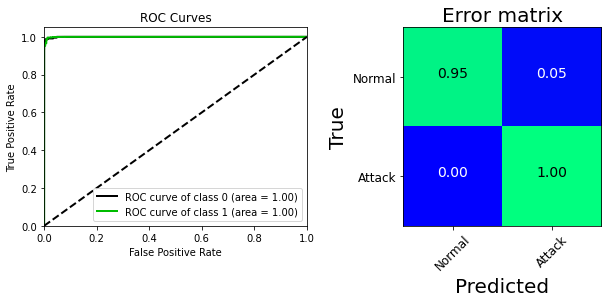

,Accuracy,Precision,Recall,F-score,MСС,ROC AUC,Log Loss
,0.997,0.997,0.997,0.997,0.995,-,-


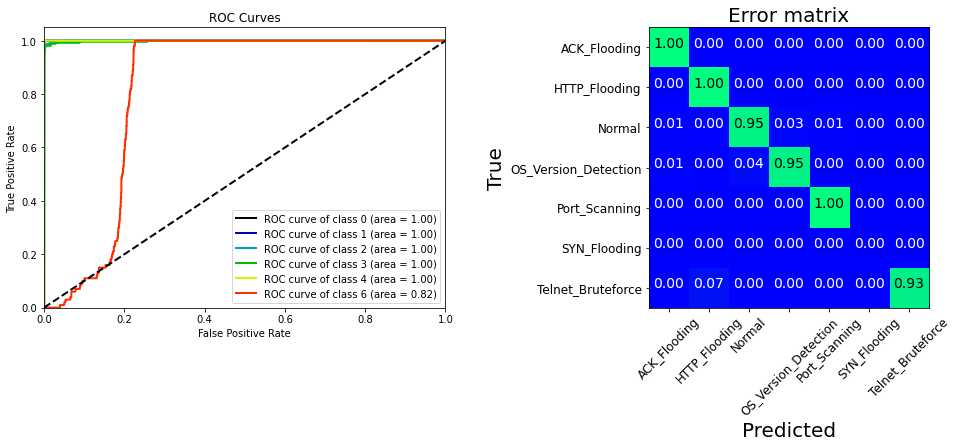

In [65]:
bin_stats = list()
multy_stats = list()
t = t_start()
if type(perceptron_model) == keras.models.Sequential:
    test_predicts_new = perceptron_model.predict(prepare(test_data, data_scaler))
else:
    test_predicts_new = perceptron_model.predict_proba(prepare(test_data, data_scaler))
t_end('Multilayer Perceptron Predict', t)
bin_stats.append([ print_stats(test_predicts_new, test_labels, label_encoder, atk_norm=True)])
multy_stats.append([ print_stats(test_predicts_new, test_labels, label_encoder, atk_norm=False)])
print('\n\n')

    Загрузка тестового даасета

In [66]:
data_new, type_attack_new = load_dataset(new_packets)

Port_Scanning : 2001
Telnet_Bruteforce : 21
ACK_Flooding : 9614
UDP_Flooding : 1
HTTP_Flooding : 294
SYN_Flooding : 17530
Normal : 1640
OS_Version_Detection : 46
Total packages : 31147



In [67]:
for cat in type_attack_new:
    if cat not in type_attack:
        data_new = data_new.drop(index=data_new.loc[data_new['category'] == cat, :].index)
type_attack_new = type_attack

data_new = shuffle(data_new, random_state=seed_value)

mean_count = int(np.array([sum(data_new['category'] == cat) for cat in type_attack_new]).mean())

for cat in type_attack:
    if sum(data_new['category'] == cat) > mean_count:
        data_new = data_new.drop(index=data_new.loc[data_new['category'] == cat, :][mean_count:].index)
type_attack_new = num_pack_atack(data_new)

test_data_new, test_labels_new = data_new.drop(columns=['category']), data_new['category']

Port_Scanning : 2001
Telnet_Bruteforce : 21
ACK_Flooding : 4449
HTTP_Flooding : 294
SYN_Flooding : 4449
Normal : 1640
OS_Version_Detection : 46
Total packages : 12900


In [68]:
test_labels_new = label_encoder.transform(test_labels_new)

In [69]:
test_data_new = test_data_new[train_data.columns]

In [70]:
perceptron_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Multilayer Perceptron Predict    : 0.312 s


,Accuracy,Precision,Recall,F-score,MСС,ROC AUC,Log Loss
,0.989,0.989,0.989,0.989,0.95,-,0.069


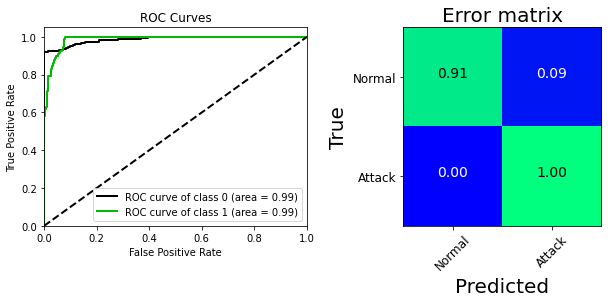

,Accuracy,Precision,Recall,F-score,MСС,ROC AUC,Log Loss
,0.816,0.912,0.816,0.83,0.779,0.947,1.546


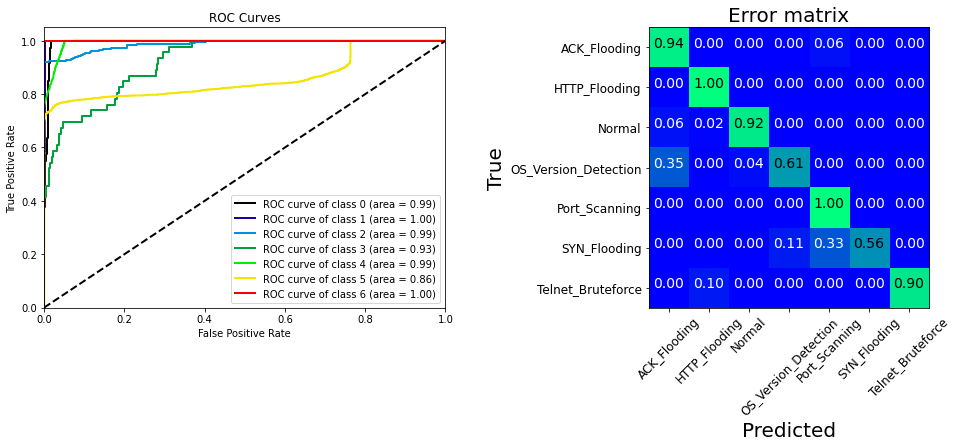

In [71]:
t = t_start()
if type(perceptron_model) == keras.models.Sequential:
    test_predicts_new = perceptron_model.predict(prepare(test_data_new, data_scaler))
else:
    test_predicts_new = perceptron_model.predict_proba(prepare(test_data_new, data_scaler))
t_end('Multilayer Perceptron Predict', t)
bin_stats.append([ print_stats(test_predicts_new, test_labels_new, label_encoder, atk_norm=True)])
multy_stats.append([ print_stats(test_predicts_new, test_labels_new, label_encoder, atk_norm=False)])
print('\n\n')